# spinal_test3.ipynb

This test is similar to `spinal_test2.ipynb`, but the plant will now be the pendulum.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


## PART 1
### The pendulum as a plant

In [2]:
# Create the neuronal populations
#des_ang = 0.2 # "predicted" perceived angle in SP
des_angs = 0.05 + 0.95*np.random.random(2000) # list of "predicted" angles
#des_vel = 0.1 # "predicted" perceived angular velocity SP
des_vels = 0.05 + 0.95*np.random.random(2000) # list of "predicted" velocities
pres_interv = 10. # interval that desired values last
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz2 = lambda : (1. + par_heter*(np.random.rand(2)-0.5))
randz4 = lambda : (1. + par_heter*(np.random.rand(4)-0.5))


# PARAMETER DICTIONARIES
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0. * randz2(),
             'slope' : 1. * randz2(),
             'init_val' : 0.2 * randz2(),
             'tau' : 0.05 * randz2() }
SP_params = {'type' : unit_types.source,
             'init_val' : [des_angs[0], des_vels[0]],
             'function' : [lambda t: des_angs[int(round(t/pres_interv))],
                           lambda t: des_vels[int(round(t/pres_interv))]] }
SPF_params = {'type' : unit_types.out_norm_sig,
              'thresh' : 0.5 * randz4(),
              'slope' : 4. * randz4(),
              'delay' : 0.32,
              'init_val' : 0.3 * randz4(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.05 * randz4(),
              'des_out_w_abs_sum' : .5 }
init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
M_params = {'type' : unit_types.am_pm_oscillator,
            'integ_meth' : 'odeint',
            'tau_u' : 0.1 * randz2(),
            'tau_c' : 0.2 * randz2(),
            'tau_t' : 1.,
            'tau_s' : 0.02,
            'init_val' : [r*init_base for r in np.random.random(2)],
            'multidim' : True,
            'omega' : 8.*np.pi,
            'F' : 'zero', #'input_sum',
            'tau_fast': 0.01,
            'tau_mid' : 0.05,
            'tau_slow' : 1.,
            'custom_inp_del' : 150,
            'delay' : 0.32,
            'mu' : 0.,
            'sigma' : 0.0 }
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }
# plant parameters
P_params = {'type' : plant_models.bouncy_pendulum,
            'length' : 0.5,
            'mass' : 1.,
            'init_angle' : 0.,
            'init_ang_vel' : 0.,
            'g' : 0.,
            'inp_gain' : 2.,
            'mu' : 0.1,
            'bound_angle' : True,
            'tau' : 0.5 } # a made-up time constant for the plant 
                          # see create_freqs_steps below

# CONNECTION DICTIONARIES
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SPF__M_conn = {'rule': 'all_to_all',
               'delay': 0.02 }
SPF__M_syn = {'type' : synapse_types.rga,
              'lrate': 50.,
              'inp_ports': 0,
              'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }
# motor units to plant
M0__P_conn = {'inp_ports' : 0,
             'delays': 0.01 }
M0__P_syn = {'type': synapse_types.static,
            'init_w' : 1.2 }
M1__P_conn = M0__P_conn
M1__P_syn = {'type': synapse_types.static,
             'init_w' : -1.2 }
# plant to sensory
P__SF_conn = {'port_map' : [[(0,0)], [(1,0)]],
              'delays' : 0.01 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : [1.5, 0.5] }
# lateral connections in M
M__M_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
M__M_syn = {'type' : synapse_types.static,
            'lrate' : 0.1,
            'inp_ports': 1,
            'init_w' : -0.1 }
            
def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        Args:
            n : number of units
            w : base omega value (rad)
            r : amplitude of noise as fraction of original value
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays. 
    """
    ws = w * (1. + r*((np.random.random(n) - 0.5)))
    ws = ws / M_params['tau_t'] # angular frequencies
    mp_del = np.arctan(np.mean(P_params['tau'])*ws)/ws
    psf_del = np.arctan(np.mean(SF_params['tau'])*ws)/ws
    sfspf_del = np.arctan(np.mean(SPF_params['tau'])*ws)/ws
    D = [M1__P_conn['delays'], P__SF_conn['delays'],
         SFe__SPF_conn['delay'], SPF__M_conn['delay']]
    d1 = mp_del + psf_del + sfspf_del + sum(D)
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

# CREATING UNITS
net = network(net_params)
SF = net.create(2, SF_params)
SP = net.create(2, SP_params)
SPF = net.create(4, SPF_params)
P = net.create(1, P_params)
# creating M with heterogeneous frequencies
omegas, del_steps = create_freqs_steps(2, M_params['omega'], par_heter)
M_params['omega'] = omegas
M_params['custom_inp_del'] = del_steps
M = net.create(2, M_params)

SPF_M0_track = net.create(4, track_params) # to track synaptic weights at M[0]
spf_diff_track = net.create(4, track_params) # to track SPF derivatives used in M
M0_I0_track = net.create(1, track_params) # to track the 4th state variable of M (I0)
xp_track = net.create(1, track_params) # del_avg_inp_deriv of M1 at port 1
up_track = net.create(1, track_params) # to track the derivative of M1
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for M1 at port 0
spj_track = net.create(1, track_params) # input derivative for SPF1--M1
dc_track = net.create(2, track_params) # DC component of M units


# CONNECTING
net.connect(SF, SPF[0::2], SFe__SPF_conn, SFe__SPF_syn) # indices 0,2
net.connect(SP, SPF[0::2], SPi__SPF_conn, SPi__SPF_syn)
net.connect(SF, SPF[1::2], SFi__SPF_conn, SFi__SPF_syn) # indices 1,3
net.connect(SP, SPF[1::2], SPe__SPF_conn, SPe__SPF_syn)
net.connect(SPF, M, SPF__M_conn, SPF__M_syn)
net.set_plant_inputs([M[0]], P, M0__P_conn, M0__P_syn)
net.set_plant_inputs([M[1]], P, M1__P_conn, M1__P_syn)
net.set_plant_outputs(P, SF, P__SF_conn, P__SF_syn)
net.connect([M[0]], [M[1]], M__M_conn, M__M_syn)
net.connect([M[1]], [M[0]], M__M_conn, M__M_syn)

# SETTING UP WEIGHT TRACKING -- depends on the order of unit creation!!!!!!
# This is dependent on the order in which net.connect is called above
net.units[SPF_M0_track[0]].set_function(lambda t: net.syns[M[0]][0].w) # SPF0--M0
net.units[SPF_M0_track[1]].set_function(lambda t: net.syns[M[0]][1].w) # SPF1--M0
net.units[SPF_M0_track[2]].set_function(lambda t: net.syns[M[0]][2].w) # SPF2--M0
net.units[SPF_M0_track[3]].set_function(lambda t: net.syns[M[0]][3].w) # SPF3--M0

# SETTING UP DERIVATIVE TRACKING
net.units[spf_diff_track[0]].set_function(lambda t: net.units[M[0]].inp_deriv_mp[0][0]) # SPF0 diff
net.units[spf_diff_track[1]].set_function(lambda t: net.units[M[0]].inp_deriv_mp[0][1]) # SPF1 diff
net.units[spf_diff_track[2]].set_function(lambda t: net.units[M[0]].inp_deriv_mp[0][2]) # SPF2 diff
net.units[spf_diff_track[3]].set_function(lambda t: net.units[M[0]].inp_deriv_mp[0][3]) # SPF3 diff

# SETTING TRACKING OF PLASTICITY FACTORS FOR SPF1-->M0
net.units[xp_track[0]].set_function(lambda t: net.units[M[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[M[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[M[0]].get_lpf_fast(po_de) - 
                                    net.units[M[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[M[0]].avg_inp_deriv_mp[0])
ds = net.syns[M[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[SPF[1]].get_lpf_fast(ds) - 
                                     net.units[SPF[1]].get_lpf_mid(ds))

# SETTING UP TRACKING OF M STATE VARIABLES
net.units[dc_track[0]].set_function(lambda t: net.units[M[0]].buffer[1, -1])
net.units[dc_track[1]].set_function(lambda t: net.units[M[1]].buffer[1, -1])

net.units[M0_I0_track[0]].set_function(lambda t: net.units[M[0]].buffer[3][-1])

In [7]:
start_time = time.time()
times, data, plant_data  = net.run(20.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 6.571476936340332 seconds


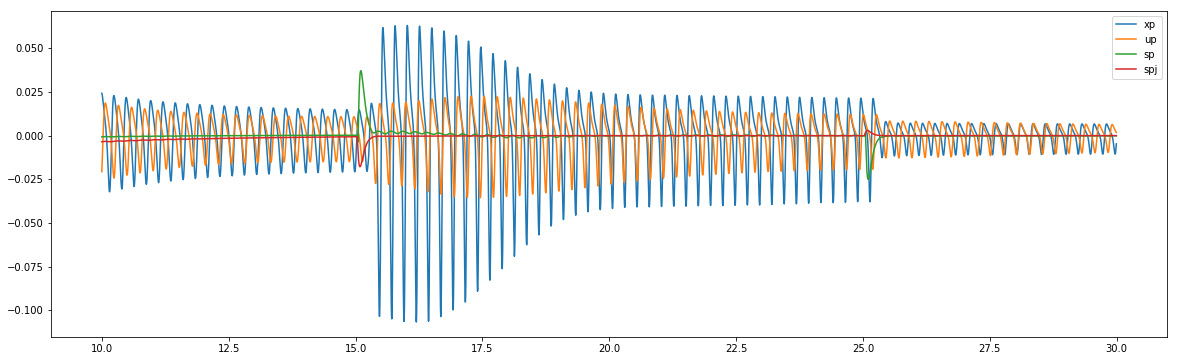

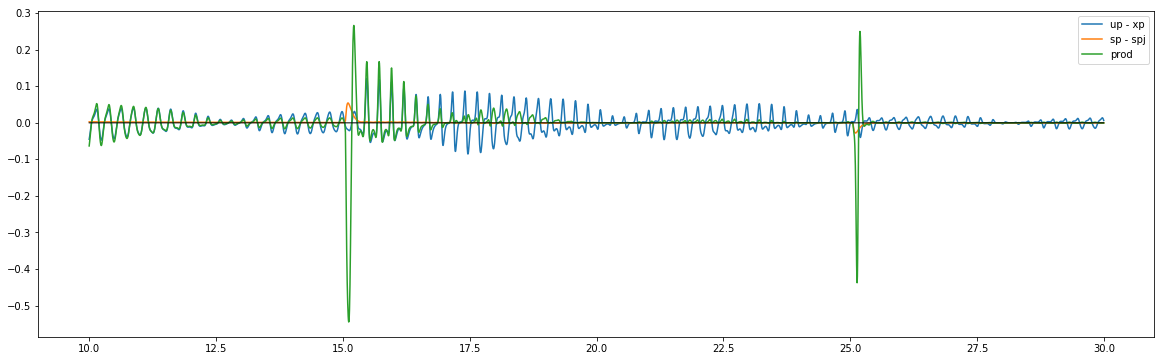

In [8]:
# plot all factors in the SPF0--M0 synaptic plasticity
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

[0.49902078 0.02113831 0.18318722 0.0755259 ]
0.9986620297300656
0.9823548703603369


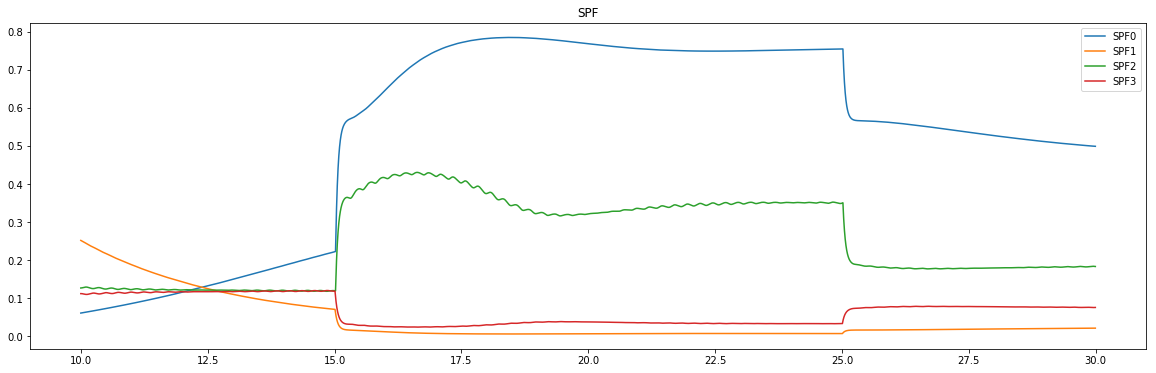

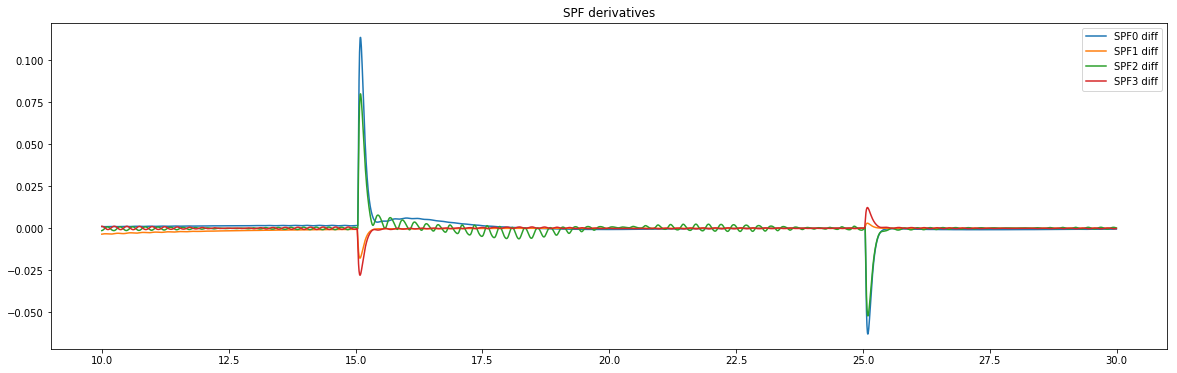

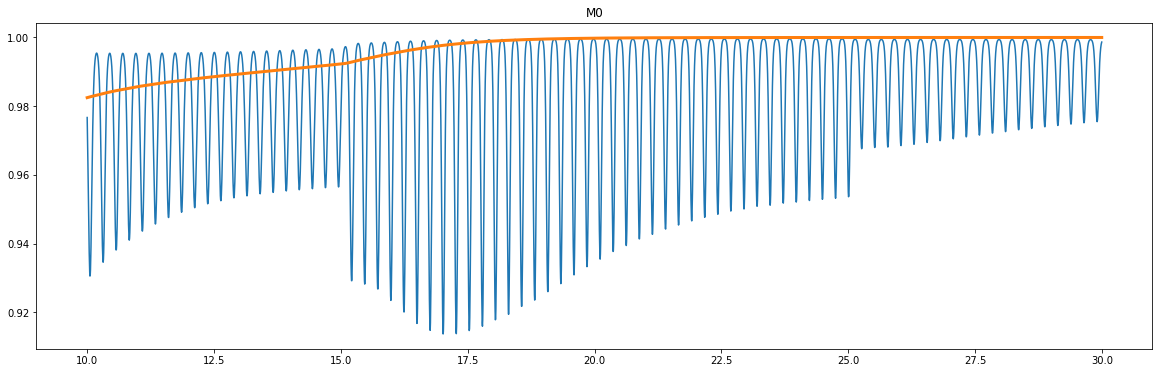

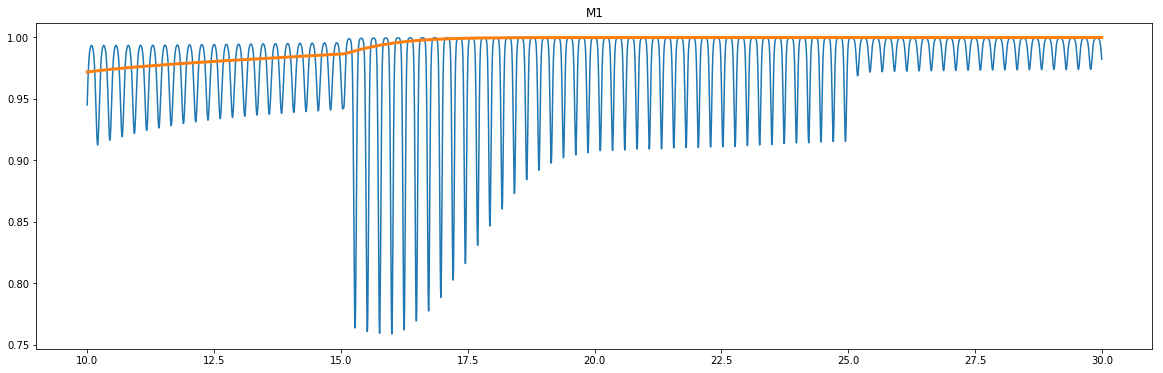

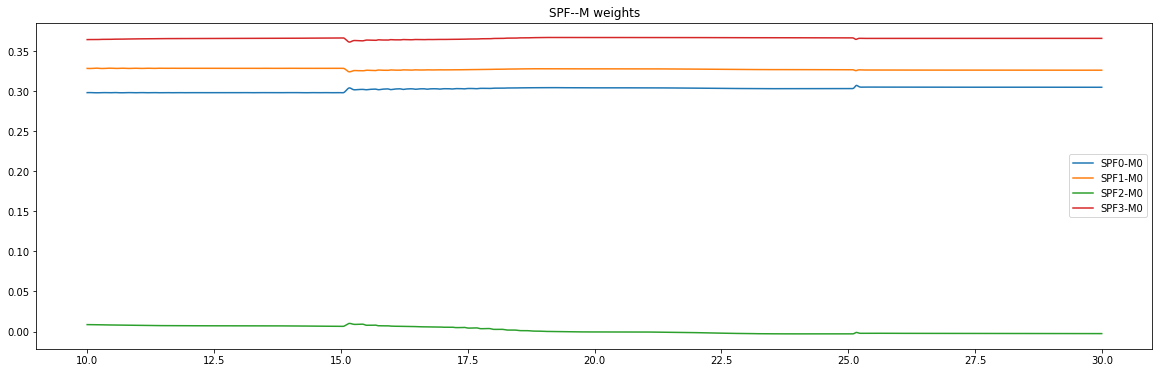

In [9]:
# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
plt.legend(['SPF0', 'SPF1', 'SPF2', 'SPF3'])
plt.title('SPF')
print(SPF_data[:,-1])

# SPF inputs derivatives
#"""
diff_fig = plt.figure(figsize=fs)
spf_diff_track_data = np.array(data[spf_diff_track])
plt.plot(times, spf_diff_track_data.transpose())
plt.legend(['SPF0 diff', 'SPF1 diff', 'SPF2 diff', 'SPF3 diff'])
plt.title('SPF derivatives')
#"""
# M0
M0_fig = plt.figure(figsize=fs)
M0_data = np.array(data[M[0]])
plt.plot(times, M0_data.transpose())
plt.plot(times, data[dc_track[0]], linewidth=3)
plt.title('M0')
print(M0_data[-1])

# M1
M1_fig = plt.figure(figsize=fs)
M1_data = np.array(data[M[1]])
plt.plot(times, M1_data.transpose())
plt.plot(times, data[dc_track[1]], linewidth=3)
plt.title('M1')
print(M1_data[-1])

# SPF--M weights
W_fig = plt.figure(figsize=fs)
w_track_data = np.array(data[SPF_M0_track])
plt.plot(times, w_track_data.transpose())
plt.legend(['SPF0-M0', 'SPF1-M0', 'SPF2-M0', 'SPF3-M0'])
plt.title('SPF--M weights')

plt.show()

angle: 1.099001, vel: -0.074595


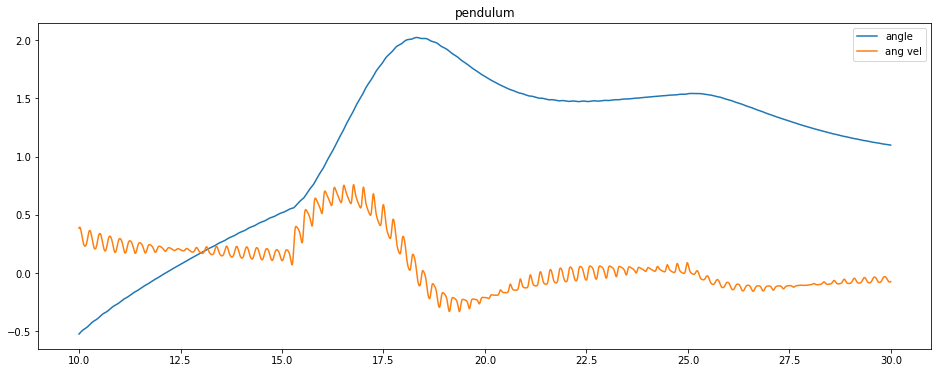

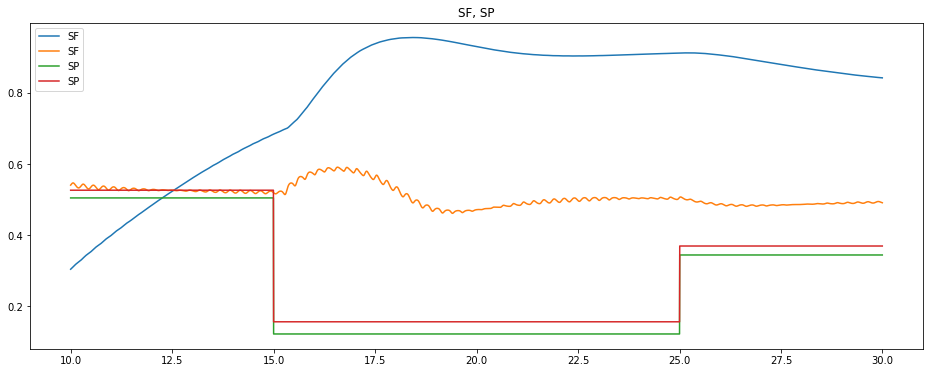

SF = [0.842161, 0.491220]
SP = [0.344506, 0.369706]


In [10]:
# P
P_fig = plt.figure(figsize=(16,6))
P_data = plant_data[P]
plt.plot(times, P_data[:,0], label='angle')
plt.plot(times, P_data[:,1], label='ang vel')
plt.legend()
plt.title('pendulum')
print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# SF, SP
SF_fig = plt.figure(figsize=(16,6))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP')
plt.legend()
plt.title('SF, SP')
plt.show()
print('SF = [%f, %f]' % (SF_data[0,-1],SF_data[1,-1]))
print('SP = [%f, %f]' % (SP_data[0,-1], SP_data[1,-1]))

In [81]:
abs_sum0 = 0.
abs_sum1 = 0.
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id == M[1]:
        pre_pop = 'M1'
    elif pre_id == M[0]:
        pre_pop = 'M0'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> M, w=%f'%(idx, pre_pop, pre_id, syn.w))
    if syn.port == 0:
        abs_sum0 += abs(syn.w)
    if syn.port == 1:
        abs_sum1 += abs(syn.w)
print("abs_sum0=%f, abs_sum1=%f" % (abs_sum0, abs_sum1))

0) SPF (4) --> M, w=0.227980
1) SPF (5) --> M, w=0.291820
2) SPF (6) --> M, w=-0.213328
3) SPF (7) --> M, w=0.266873
4) M1 (9) --> M, w=-0.500000
abs_sum0=1.000000, abs_sum1=0.500000


In [67]:
abs_sum0 = 0.
abs_sum1 = 0.
for idx, syn in enumerate(net.syns[M[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id == M[1]:
        pre_pop = 'M1'
    elif pre_id == M[0]:
        pre_pop = 'M0'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> M, w=%f'%(idx, pre_pop, pre_id, syn.w))
    if syn.port == 0:
        abs_sum0 += abs(syn.w)
    if syn.port == 1:
        abs_sum1 += abs(syn.w)
print("abs_sum0=%f, abs_sum1=%f" % (abs_sum0, abs_sum1))

0) SPF (4) --> M, w=0.288475
1) SPF (5) --> M, w=0.220332
2) SPF (6) --> M, w=0.325528
3) SPF (7) --> M, w=-0.165677
4) M0 (8) --> M, w=-0.500000
abs_sum0=1.000012, abs_sum1=0.500000


In [17]:
uid = SPF[3]
unit = net.units[uid]
w_sum = 0.
for list_idx, syn_list in enumerate(net.syns):
    for syn_idx, syn in enumerate(syn_list):
        if syn.preID == uid:
            w_sum += abs(syn.w)
w_sum

0.4998072119349057

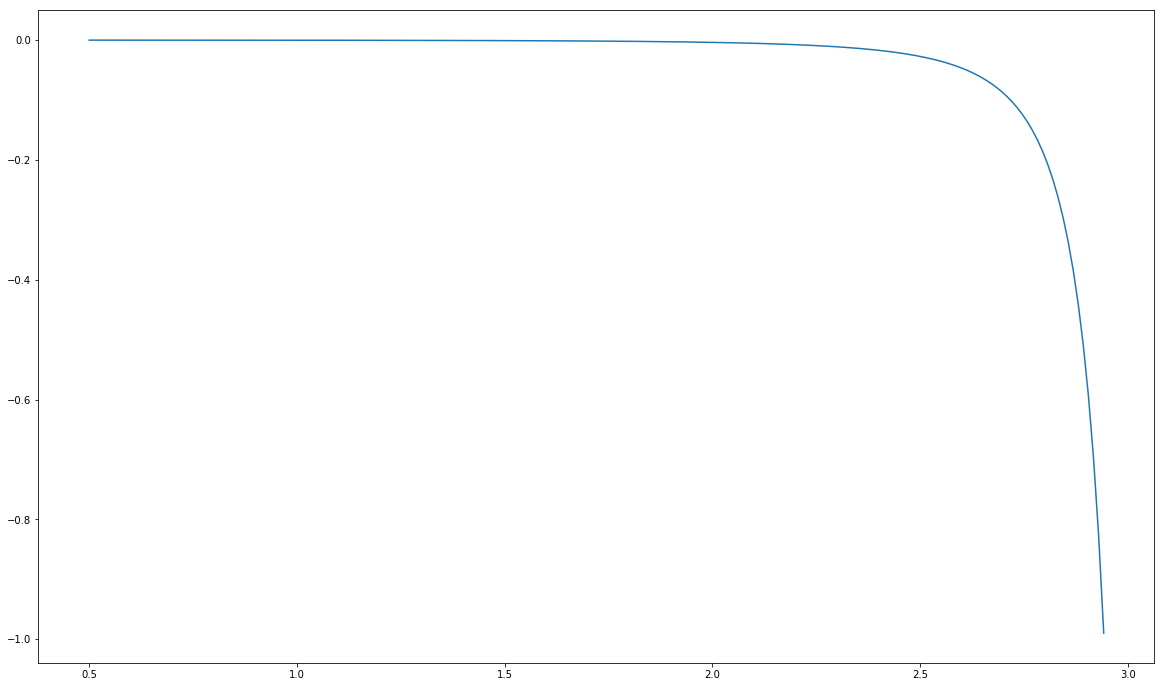

In [17]:
angs = np.linspace(0.5, np.pi-0.2, 200)
vals = -(np.tan(angs/2.)/10.)**3
fig = plt.figure(figsize=(20,12))
plt.plot(angs,vals)
plt.show()

## PART 2
### Using an M-S layer with the pendulum
According to the reduced model from 6/6/19

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
# Create the neuronal populations
des_angs = 0.05 + 0.95*np.random.random(1000) # list of "predicted" angles
pres_interv = 20. # interval that desired values last
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz2 = lambda : (1. + par_heter*(np.random.rand(2)-0.5))
randz4 = lambda : (1. + par_heter*(np.random.rand(4)-0.5))


# PARAMETER DICTIONARIES
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.,
             'slope' : 1.,
             'init_val' : 0.2,
             'tau' : 0.02 }  # 0.05
SP_params = {'type' : unit_types.source,
             'init_val' : des_angs[0],
             'function' : lambda t: des_angs[int(round(t/pres_interv))] }
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.5 * randz2(),
              'slope' : 4. * randz2(),
              'init_val' : 0.3 * randz2(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz2() } # 0.05
M_params = {'type' : unit_types.out_norm_am_sig,
            'thresh' : -0.1 * randz2(),
            'slope' : 3. * randz2(),
            'init_val' : 0.2 * randz2(),
            'delay' : 0.2,
            'tau_fast': 0.01,
            'tau_mid': 0.05,
            'tau_slow' : 2.,
            'tau' : 0.01 * randz2(),
            'des_out_w_abs_sum' : 1. }
init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
C_params = {'type' : unit_types.am_pm_oscillator,
            'integ_meth' : 'odeint',
            'tau_u' : 0.4 * randz2(), # 0.1
            'tau_c' : 0.1 * randz2(), # 0.2
            'tau_t' : 1.,
            'tau_s' : 0.02,
            'init_val' : [r*init_base for r in np.random.random(2)],
            'multidim' : True,
            'omega' : 8.*np.pi,
            'F' : 'zero', #'input_sum',
            'tau_fast': 0.01,
            'tau_mid' : 0.05,
            'tau_slow' : 2.,
            'custom_inp_del' : 150,
            'delay' : 0.2,
            'mu' : 0.,
            'sigma' : 0.0 }
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }
# plant parameters
P_params = {'type' : plant_models.bouncy_pendulum,
            'length' : 0.5,
            'mass' : 1.,
            'init_angle' : 0.,
            'init_ang_vel' : 0.,
            'g' : 0.,
            'inp_gain' : 2.,
            'mu' : 0.2,
            'bound_angle' : True,
            'pi_visco' : 0.05,
            'tau' : 0.05 } # a made-up time constant for the plant 
                          # see create_freqs_steps below
A_params = {'type' : unit_types.logarithmic,
            'init_val' : 0.,
            'tau' : 0.01, # 0.02
            'tau_fast': 0.005,
            'thresh' : 0. }

# CONNECTION DICTIONARIES
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.inp_corr,
              'inp_ports' : 1,
              'lrate' : 0.,
              'input_type' : 'error',
              'init_w' : 1. }
M__C_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__C_syn = {'type' : synapse_types.rga,
            'lrate': 50.,
            'inp_ports': 0,
            'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }
# spinal units to plant
C0__P_conn = {'inp_ports' : 0,
             'delays': 0.01 }
C0__P_syn = {'type': synapse_types.static,
            'init_w' : 2. }
C1__P_conn = C0__P_conn
C1__P_syn = {'type': synapse_types.static,
             'init_w' : -2. }
A__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
A__M_syn = {'type' : synapse_types.inp_corr,
            'inp_ports' : 0, # afferent for inp_sel, and for out_norm_am_sig
            'input_type' : 'pred',
            'lrate' : 20.,
            'init_w' : .1 }
# plant to sensory/motor
P__SF_conn = {'port_map' : [(0,0)],
              'delays' : 0.01 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
P__A_conn = {'port_map' : [[(0,0)], [(1,0)], [(0,0)], [(1,0)]],
             'delays' : 0.02 }
P__A_syn = {'type' : synapse_types.static,
            'init_w' : [1., 1., -1., -1.] }
# lateral connections in M
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn = {'type' : synapse_types.static,
            'lrate' : 0.1,
            'inp_ports': 1,
            'init_w' : -1. }

def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-P-M-C
        Args:
            n : number of units
            w : base omega value (rad)
            r : amplitude of noise as fraction of original value
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays. 
    """
    ws = w * (1. + r*((np.random.random(n) - 0.5)))
    ws = ws / C_params['tau_t'] # angular frequencies
    cp_del = np.arctan(np.mean(P_params['tau'])*ws)/ws
    pm_del = np.arctan(np.mean(M_params['tau'])*ws)/ws
    am_del = np.arctan(np.mean(A_params['tau'])*ws)/ws
    D = [C0__P_conn['delays'], np.mean(P__A_conn['delays']), 
         A__M_conn['delay'], M__C_conn['delay'] ]
    d1 = cp_del + pm_del + am_del + sum(D)
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

# CREATING UNITS
net = network(net_params)
SF = net.create(1, SF_params)
SP = net.create(1, SP_params)
SPF = net.create(2, SPF_params)
M = net.create(2, M_params)
P = net.create(1, P_params)
A = net.create(4, A_params)
# creating C with heterogeneous frequencies
omegas, del_steps = create_freqs_steps(2, C_params['omega'], par_heter)
C_params['omega'] = omegas
C_params['custom_inp_del'] = del_steps
C = net.create(2, C_params)

# tracking units
M_C0_track = net.create(2, track_params) # to track weights from M to C0
A_M0_track = net.create(4, track_params) # to track weights from A to M0
xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of C0
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for C0 at port 0
spj_track = net.create(1, track_params) # input derivative for SPF0--C0
dc_track = net.create(2, track_params) # DC component of C units

# CONNECTING
net.connect(SF, SPF[0:-1], SFe__SPF_conn, SFe__SPF_syn) # index 0
net.connect(SP, SPF[0:-1], SPi__SPF_conn, SPi__SPF_syn)
net.connect(SF, SPF[1:], SFi__SPF_conn, SFi__SPF_syn) # index 1
net.connect(SP, SPF[1:], SPe__SPF_conn, SPe__SPF_syn)
net.connect(M, C, M__C_conn, M__C_syn)
net.set_plant_inputs([C[0]], P, C0__P_conn, C0__P_syn)
net.set_plant_inputs([C[1]], P, C1__P_conn, C1__P_syn)
net.set_plant_outputs(P, SF, P__SF_conn, P__SF_syn)
net.set_plant_outputs(P, A, P__A_conn, P__A_syn)
net.connect(A, M, A__M_conn, A__M_syn) # this connection should be made before 
net.connect(SPF, M, SPF__M_conn, SPF__M_syn) # this connection is made after
net.connect([C[0]], [C[1]], C__C_conn, C__C_syn)
net.connect([C[1]], [C[0]], C__C_conn, C__C_syn)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This is dependent on the order in which net.connect is called above;
net.units[M_C0_track[0]].set_function(lambda t: net.syns[C[0]][0].w) # M0--C0
net.units[M_C0_track[1]].set_function(lambda t: net.syns[C[0]][1].w) # M1--C0
# Nothing should connect to M0 before A
net.units[A_M0_track[0]].set_function(lambda t: net.syns[M[0]][0].w) # P0--M0
net.units[A_M0_track[1]].set_function(lambda t: net.syns[M[0]][1].w) # P1--M0
net.units[A_M0_track[2]].set_function(lambda t: net.syns[M[0]][2].w) # -P0--M0
net.units[A_M0_track[3]].set_function(lambda t: net.syns[M[0]][3].w) # -P1--M0

# SETTING TRACKING OF PLASTICITY FACTORS FOR M0-->C0
net.units[xp_track[0]].set_function(lambda t: net.units[C[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[C[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[C[0]].get_lpf_fast(po_de) - 
                                    net.units[C[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[C[0]].avg_inp_deriv_mp[0])
ds = net.syns[C[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[M[0]].get_lpf_fast(ds) - 
                                     net.units[M[0]].get_lpf_mid(ds))

# SETTING UP TRACKING OF C STATE VARIABLES
net.units[dc_track[0]].set_function(lambda t: net.units[C[0]].buffer[1, -1])
net.units[dc_track[1]].set_function(lambda t: net.units[C[1]].buffer[1, -1])


In [3]:
start_time = time.time()
times, data, plant_data  = net.flat_run(200.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

/home/z/projects/draculab/network.py:915: UserWarning: Integration method odeint substituted by Forward Euler in some units
  ' substituted by Forward Euler in some units', UserWarning)


Execution time is 63.159252405166626 seconds


[0.01039481 0.65222171]
[0.00586164 0.62855591]
0.04067318557317915
0.999762931994312


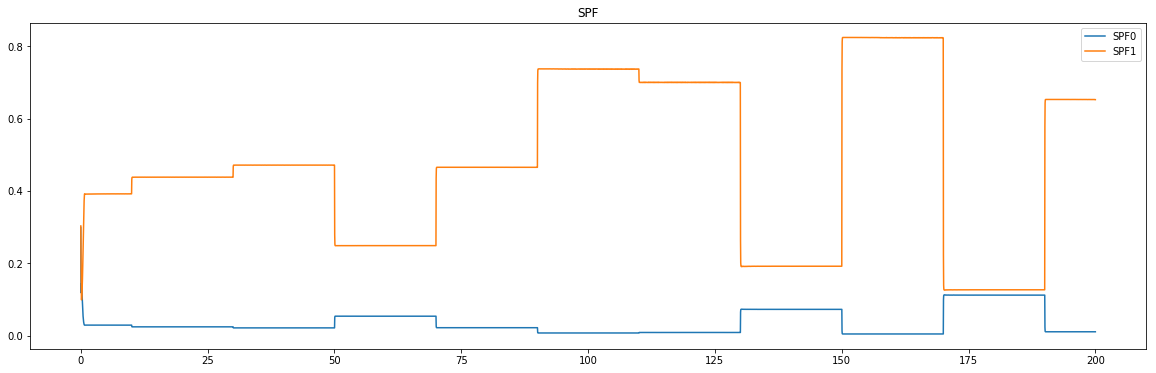

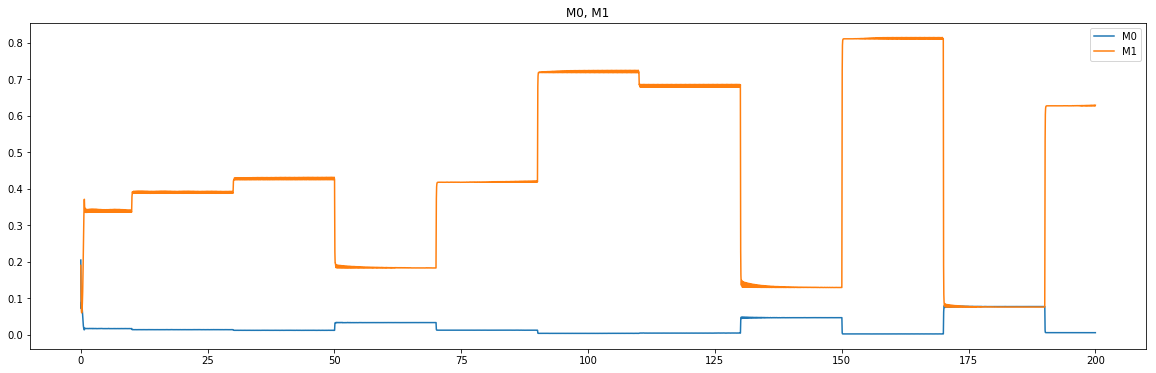

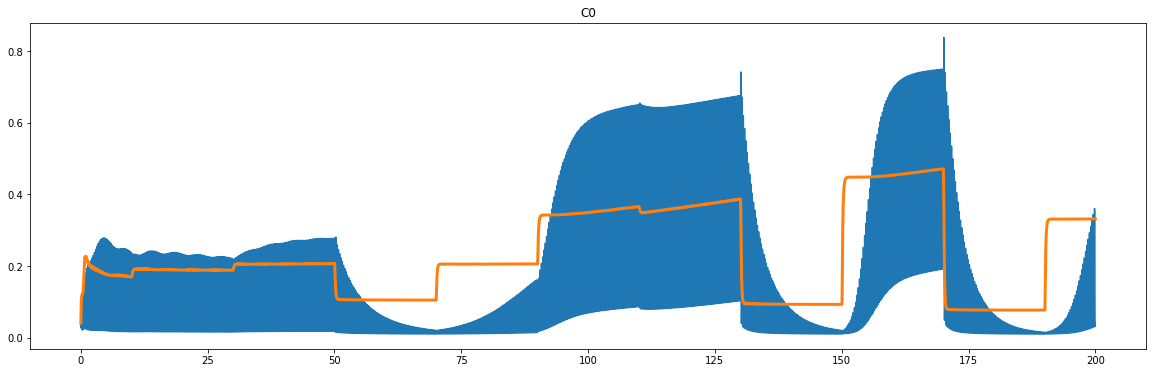

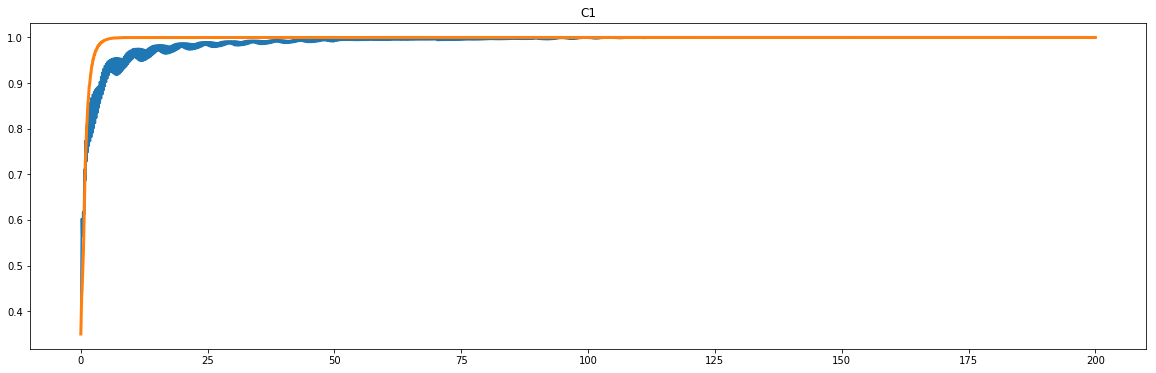

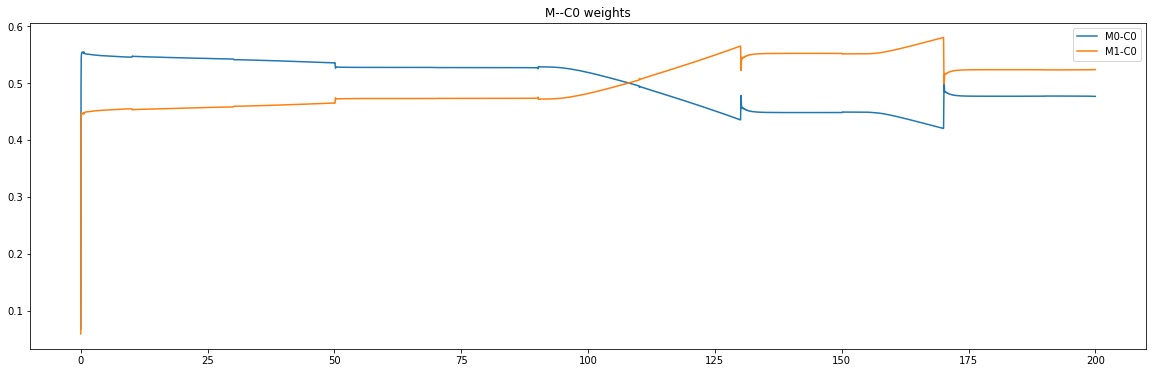

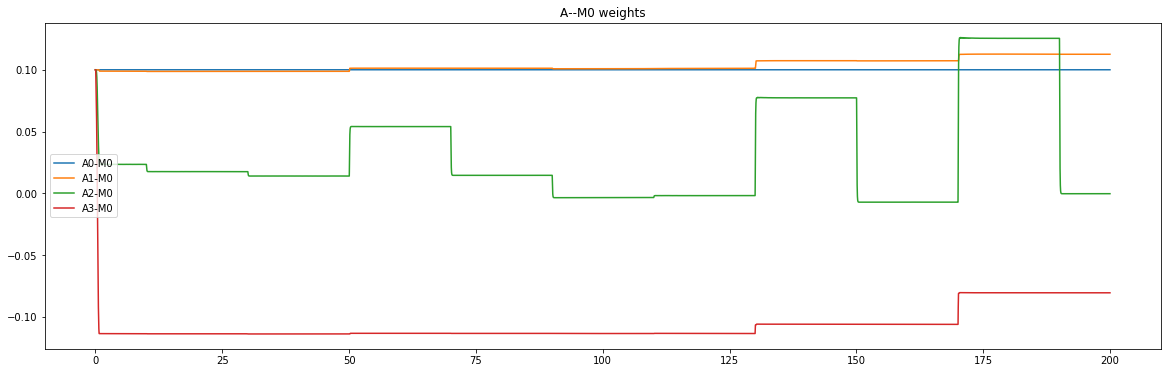

In [4]:
# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
plt.legend(['SPF0', 'SPF1'])
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
plt.legend(['M0', 'M1'])
plt.title('M0, M1')
print(M_data[:,-1])

# C0
C0_fig = plt.figure(figsize=fs)
C0_data = np.array(data[C[0]])
plt.plot(times, C0_data.transpose())
plt.plot(times, data[dc_track[0]], linewidth=3)
plt.title('C0')
print(C0_data[-1])

# C1
C1_fig = plt.figure(figsize=fs)
C1_data = np.array(data[C[1]])
plt.plot(times, C1_data.transpose())
plt.plot(times, data[dc_track[1]], linewidth=3)
plt.title('C1')
print(C1_data[-1])

# M--C0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_C0_track])
plt.plot(times, w_track_data.transpose())
plt.legend(['M0-C0', 'M1-C0'])
plt.title('M--C0 weights')

# A--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track])
plt.plot(times, w_track_data2.transpose())
plt.legend(['A0-M0', 'A1-M0', 'A2-M0', 'A3-M0'])
plt.title('A--M0 weights')

plt.show()

angle: -3.013826, vel: -0.107582
[0.00000000e+00 3.64556067e-05 1.38853746e+00 1.79643663e-01]


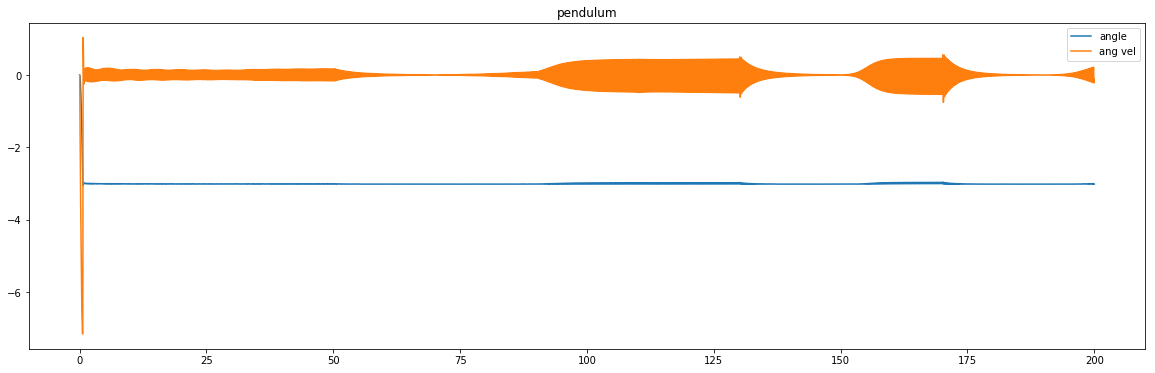

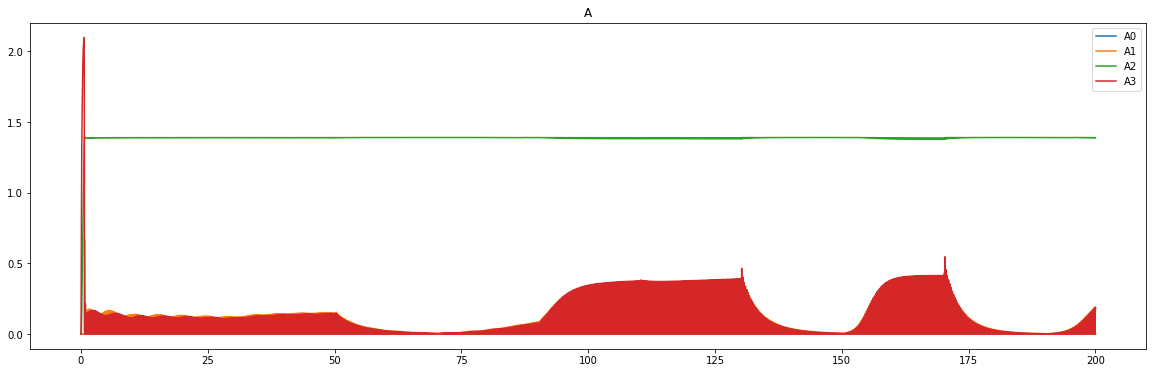

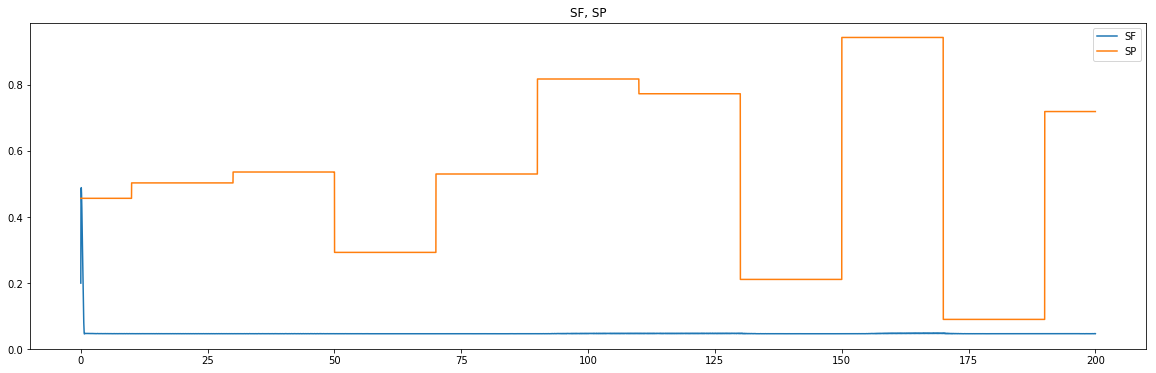

SF = [0.047020]
SP = [0.718987]


In [5]:
# P
P_fig = plt.figure(figsize=fs)
P_data = plant_data[P]
plt.plot(times, P_data[:,0], label='angle')
plt.plot(times, P_data[:,1], label='ang vel')
plt.legend()
plt.title('pendulum')
print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A])
plt.plot(times, A_data.transpose())
plt.legend(['A0', 'A1', 'A2', 'A3'])
plt.title('A')
print(A_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP')
plt.legend()
plt.title('SF, SP')
plt.show()
print('SF = [%f]' % (SF_data[0,-1]))
print('SP = [%f]' % (SP_data[0,-1]))

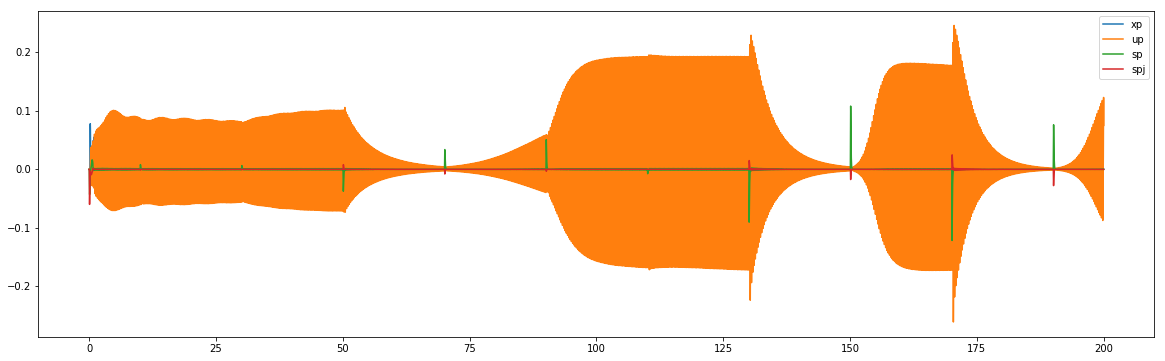

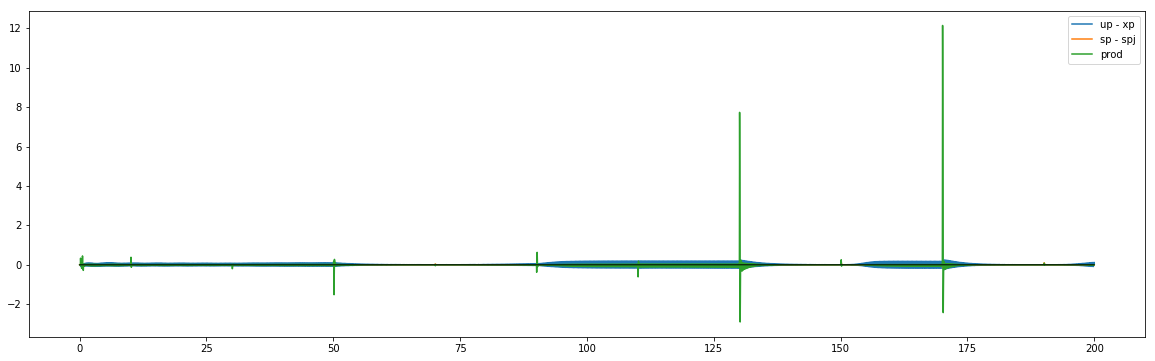

In [6]:
# plot all factors in the M--C0 synaptic plasticity
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

In [7]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

    
print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))

Connections to motor units
0) A (6) --> M, w=0.733690, port=0, plant_out=None
1) A (7) --> M, w=1.969403, port=0, plant_out=None
2) A (8) --> M, w=-0.273184, port=0, plant_out=None
3) A (9) --> M, w=-2.154270, port=0, plant_out=None
4) SPF (2) --> M, w=1.000000, port=1, plant_out=None
Connections to afferent units
0) P (0) --> A, w=-1.000000, port=0, plant_out=0
Connections to plant
0) C (10, unit_types.am_pm_oscillator) --> P, w=2.000000
1) C (11, unit_types.am_pm_oscillator) --> P, w=-2.000000


---

/home/z
Execution time is 1.0843985080718994 seconds


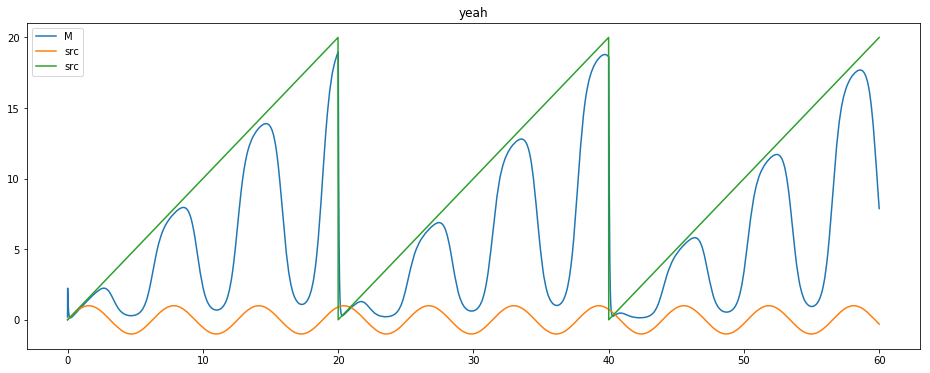

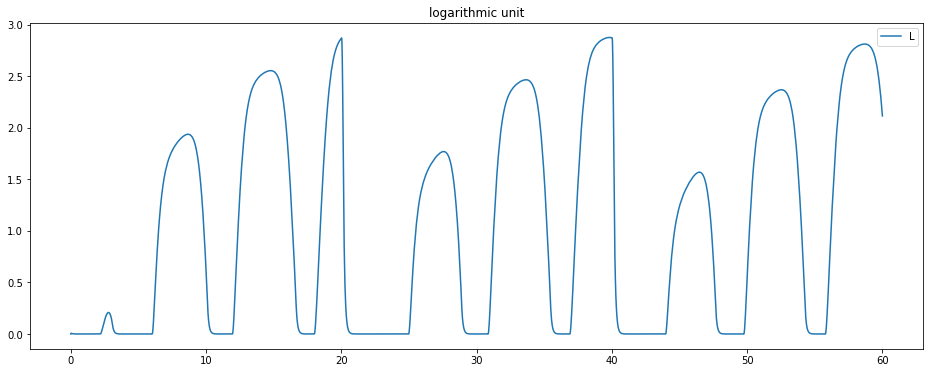

In [3]:
# cell to test the out_norm_am_sig and logarithmic units

%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
M_params = {'type' : unit_types.out_norm_am_sig,
            'thresh' : -0.1,
            'slope' : 3.,
            'init_val' : 0.2,
            'delay' : 0.2,
            'tau_fast': 0.01,
            'tau_mid': 0.05,
            'tau_slow' : 2.,
            'tau' : 0.05,
            'des_out_w_abs_sum' : 1. }
L_params = {'type' : unit_types.logarithmic,
            'init_val' : 0.,
            'tau' : 0.1,
            'thresh' : 2. }
SP_params = {'type' : unit_types.source,
             'init_val' : 0.,
             'function' : lambda t: np.sin(t) }
SP__M_syn = {'type' : synapse_types.static,
             'inp_ports' : 0,
             'init_w' : 1. }
SP__M_conn = {'rule' : 'one_to_one',
              'delay' : 0.01 }
M__L_syn = {'type' : synapse_types.static,
            'init_w' : 1. }
M__L_conn = {'rule' : 'one_to_one',
             'delay' : 0.01 }


net = network(net_params)
M = net.create(1, M_params)
L = net.create(1, L_params)
src = net.create(2, SP_params)
net.units[src[1]].set_function(lambda t: t%20 )
net.connect(src[0:-1], M, SP__M_conn, SP__M_syn)
SP__M_syn['inp_ports'] = 1
net.connect(src[1:], M, SP__M_conn, SP__M_syn)
net.connect(M, L, M__L_conn, M__L_syn)

start_time = time.time()
times, data, plant_data  = net.flat_run(60.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

fig = plt.figure(figsize=(16,6))
M_data = np.array(data[M[0]])
src_data = np.array(data[src])
plt.plot(times, M_data, label='M')
plt.plot(times, src_data.transpose(), label='src')
plt.legend()
plt.title('yeah')

fig = plt.figure(figsize=(16,6))
L_data = np.array(data[L[0]])
plt.plot(times, L_data, label='L')
plt.legend()
plt.title('logarithmic unit')

plt.show()